<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Let's look at truncation of the SVD spectrum as a regularization device

### Recall that regularization refers to any approach that makes an illposed/underdetermined parameter estimation problem solvable.  Therefore, when you manually reduce the number of parameters such as zones you are doing a type of regularization.  

### Singular Value Decomposition can be thought of as operating in a similar fashion but is automated, and more clever.  Using the Jacobian matrix, it reduces the number of base parameters by making linear combinations of the base parameters.  Thus two perfectly correlated parameters become 1 combined parameter, which helps give a unique solution to the parameter estimation problem. Those linear combinations (__=singular values__) that are in the noise (__=null space__) get truncated (__=removed from the parameter estimation process__).  This means that insensitive parameters don't adversely affect the parameter estimation process.  Those linear combinations that remain (__=solution space__) are then used to solve the parameters estimation problem.  

### Truncated SVD approach makes for a parameter estimation process that is __*unconditionally stable*__, which means it is guaranteed to be well-posed, and solvable. But the number of singular values also controls, in a somewhat brute force way, the degree of parameter smoothing and fit. The key to stability and degree of smoothing is this truncation process, which we'll dig into here.


In [1]:
import os, shutil
import sys
sys.path.append('..')
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tsvd_helper as th


## We can work with the pilot points model, so we will copy over the pilot points files

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP
shutil.copy2(os.path.join(fs.BASE_MODEL_DIR,'hk.truth.ref'), os.path.join(working_dir,'hk.truth.ref'))

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following 

'freyberg_pp/hk.truth.ref'

# First, let's make the Jacobian matrix at the starting conditions

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))
inpst.control_data.noptmax=-1
inpst.write(os.path.join(working_dir,'freyberg_jac.pst'))


In [4]:
os.chdir('freyberg_pp')
pyemu.helpers.start_slaves('.',"pestpp",'freyberg_jac.pst',num_slaves=15,master_dir='.')
os.chdir('..')

master:./pestpp freyberg_jac.pst /h :4004 in .
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_0
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_1
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_2
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_3
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_4
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_5
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_6
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_7
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_8
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_9
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_10
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_11
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_12
slave:./pestpp freyberg_jac.pst /h localhost:4004 in ../slave_13
slave:./pestpp freyberg_jac.pst /h localhost:4004 in 

# in `pyemu` we can read in the  Jacobian and, if we form the Schur complement object, we also get $\mathbf{X}^T\mathbf{Q}\mathbf{X}$

In [5]:
injac = pyemu.Schur(os.path.join(working_dir,'freyberg_jac.jcb'))

## now let's look at the singular value spectrum

In [6]:
U,S,V = np.linalg.svd(injac.xtqx.df())

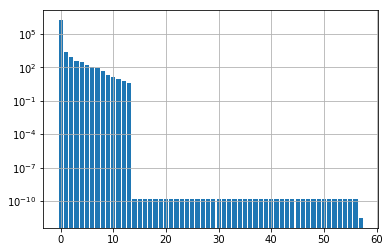

In [7]:
plt.bar(range(len(S)),S)
plt.yscale('log')
plt.grid('on')

# So what if we only use parameters comprising the first 2 singular vectors?

In [8]:
inpst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))

In [9]:
inpst.pestpp_options['n_iter_super'] = 100
inpst.pestpp_options['max_n_super'] = 2

inpst.pestpp_options

{'forecasts': 'fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,flx_river_l_19750102,travel_time',
 'lambda_scale_fac': '1.0',
 'lambdas': '0.1,1.0,10.0',
 'max_n_super': 2,
 'n_iter_base': '-1',
 'n_iter_super': 100,
 'upgrade_augment': 'false'}

In [10]:
inpst.write(os.path.join(working_dir,'freyberg_TSVD.pst'))


In [11]:
os.chdir('freyberg_pp')
pyemu.helpers.start_slaves('.',"pestpp",'freyberg_TSVD.pst',num_slaves=15,master_dir='.')
os.chdir('..')

master:./pestpp freyberg_TSVD.pst /h :4004 in .
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_0
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_1
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_2
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_3
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_4
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_5
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_6
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_7
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_8
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_9
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_10
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_11
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_12
slave:./pestpp freyberg_TSVD.pst /h localhost:4004 in ../slave_13
slave:./pestpp freyberg_TSVD.pst /h lo

In [12]:
indf = pd.read_csv(os.path.join(working_dir,'freyberg_TSVD.iobj'))

In [13]:
indf

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,calflux,calhead,flx_constan,flx_in-out,flx_percent,...,head,pothead,vol_constan,vol_in-out,vol_percent,vol_recharg,vol_river_l,vol_storage,vol_total,vol_wells
0,0,0,1378.750,1378.750,0,56.345400,1322.400,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,65,1022.230,1022.230,0,222.712000,799.523,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,74,754.165,754.165,0,0.539292,753.626,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,83,753.389,753.389,0,0.319396,753.070,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,94,737.193,737.193,0,0.233306,736.960,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,105,737.180,737.180,0,0.251526,736.929,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,116,737.180,737.180,0,0.250083,736.930,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
os.chdir('freyberg_pp')
th.update_K('freyberg_TSVD.pst')
os.chdir('..')

run():./pestpp freyberg_TSVD_opt.pst


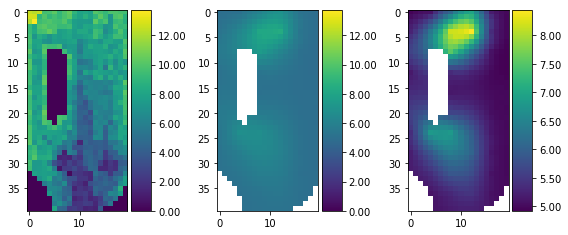

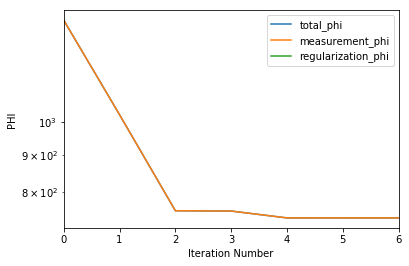

In [15]:
th.plot_K_results(working_dir, 'freyberg_TSVD')

# How does this compare with the pilot points solution?

In [16]:
inpst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))


In [17]:
os.chdir('freyberg_pp')
pyemu.helpers.start_slaves('.',"pestpp",'freyberg_pp.pst',num_slaves=15,master_dir='.')
os.chdir('..')

master:./pestpp freyberg_pp.pst /h :4004 in .
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [18]:
os.chdir('freyberg_pp')
th.update_K('freyberg_pp.pst')
os.chdir('..')

run():./pestpp freyberg_pp_opt.pst


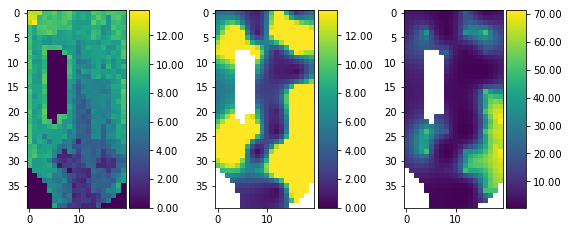

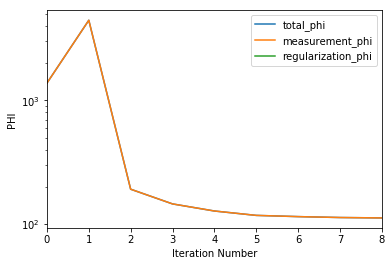

In [19]:
th.plot_K_results(working_dir, 'freyberg_pp')